# Red neuronal de clasificación de vinos
#Por: Hugo Alejandro Hinojosa Novales

In [ ]:
#Primero, importamos todas las librerías que utilizaremos

import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import time
import h5py
import zipfile
import numpy as np
import pandas as pd
import IPython.display
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import csv

In [ ]:
#Luego, vamos a exportar nuestro dataset, el cual se organizó previamente como un archivo csv. Se pudo hacer gracias a la aplicación nano que toma lectura de archivos.data, y se pudieron trasladas a un csv

from google.colab import files

uploaded = files.upload()

Saving wine.csv to wine.csv


In [ ]:
#Indicamos que las columnas se separan según aparezca una coma

df1 = pd.read_csv("wine.csv", sep=",")

In [ ]:
#Y vemos el dataframe generado

df1

,Wine,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_of_diluted_wines,0D315_of_diluted_wines,Proline
0,0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,0,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,0,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,2,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,2,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,2,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [ ]:
#Una vez que ya se tienen los datos listos, se deben de separar los datos en una parte de
#entrenamiento, validación y prueba, en este caso, con iloc indicaremos qué columnas y filas queremos
#específicamente , en este caso, el segundo argumento siempre será ":", indicando que queremos todas
#las columnas, no sin antes reordenar

df1 = df1.sample(frac=1)

In [ ]:
df1 = df1.drop('Wine', axis=1)

In [ ]:
len(df1.values[:,:])

178

In [ ]:
#Ya con el reordenamiento, hacemos lo antes dicho

a = int(0.8 * len(df1.values[:,:]))

a

142

In [ ]:
df_train = df1.iloc[0:142,:]
df_valid = df1.iloc[142:160,:]
df_test = df1.iloc[160:,:]

In [ ]:
#Veamos la forma que tienen los datos

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(142, 14)
(18, 14)
(18, 14)


In [ ]:
#Ahora sí, es el momento de separar los datos en las x, y

train_x = df_train.values[:,1:]
train_y = df_train.values[:,:1]

valid_x = df_valid.values[:,1:]
valid_y = df_valid.values[:,:1]

test_x = df_test.values[:,1:]
test_y = df_test.values[:,:1]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(142, 13)
(142, 1)
(18, 13)
(18, 1)
(18, 13)
(18, 1)


In [ ]:
#Y los normalizamos de la forma usual, con la media y el error estándar

mu1 = train_x.mean()
sigma1 = train_x.std()

mu2 = valid_x.mean()
sigma2 = valid_x.std()

mu3 = test_x.mean()
sigma3 = test_x.std()

x_train_norm = (train_x - mu1)/sigma1
x_valid_norm = (valid_x - mu2)/sigma2
x_test_norm = (test_x - mu3)/sigma3

In [ ]:
#Y su forma

print(x_train_norm.shape)
print(train_y.shape)
print(x_valid_norm.shape)
print(valid_y.shape)
print(x_test_norm.shape)
print(test_y.shape)

(142, 13)
(142, 1)
(18, 13)
(18, 1)
(18, 13)
(18, 1)


In [ ]:
#Teniendo todos los datos divididos de la mejor forma, es tiempo de crear la red neuronal
#correspondiente. Tres capas serán suficientes, evaluaremos distintos modelos cambiando solo los
#parámetros de esta función para no tener que andarla repitiendo

def architecture(n_hidden1, n_hidden2, initializer, activation, input_shape, classes):

    model = Sequential()

    model.add(Dense(units=n_hidden1,
                    kernel_initializer=initializer,
                    bias_initializer='zeros',
                    activation=activation,
                    input_shape=input_shape,))

    model.add(Dense(units=n_hidden2,
                    kernel_initializer=initializer,
                    bias_initializer='zeros',
                    activation=activation,))

    model.add(Dense(units=classes,
                    kernel_initializer=initializer,
                    bias_initializer='zeros',
                    activation = 'softmax'))

    return model

In [ ]:
#Establecemos los hiperparámetros del primero modelo a evaluar

M1capa1 = 13
M1capa2 = 7
M1init = 'uniform'
M1act = 'relu'
M1input = (13,)
M1clas = 3

In [ ]:
modell = architecture(M1capa1, M1capa2, M1init, M1act, M1input, 3)

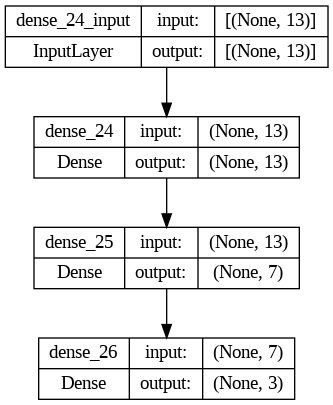

In [ ]:
#Podemos visualizar el modelo

plot_model(modell, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Los optimizadores, pérdida y métrica

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
acc = 'accuracy'

In [ ]:
#Y compilamos

modell.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = acc)

In [ ]:
#Para finalmente correrlo

num_epochs = 100

history_model = modell.fit(train_x,train_y, epochs=num_epochs, batch_size = 32, \
                          validation_data=(valid_x,valid_y), shuffle=False, verbose=2)

Epoch 1/100
5/5 - 0s - loss: 0.5507 - accuracy: 0.6972 - val_loss: 0.7737 - val_accuracy: 0.6667 - 85ms/epoch - 17ms/step
Epoch 2/100
5/5 - 0s - loss: 0.5499 - accuracy: 0.6972 - val_loss: 0.7731 - val_accuracy: 0.6667 - 42ms/epoch - 8ms/step
Epoch 3/100
5/5 - 0s - loss: 0.5490 - accuracy: 0.6972 - val_loss: 0.7731 - val_accuracy: 0.6667 - 46ms/epoch - 9ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5482 - accuracy: 0.6972 - val_loss: 0.7730 - val_accuracy: 0.6667 - 50ms/epoch - 10ms/step
Epoch 5/100
5/5 - 0s - loss: 0.5475 - accuracy: 0.6972 - val_loss: 0.7721 - val_accuracy: 0.6667 - 44ms/epoch - 9ms/step
Epoch 6/100
5/5 - 0s - loss: 0.5467 - accuracy: 0.6972 - val_loss: 0.7710 - val_accuracy: 0.6667 - 56ms/epoch - 11ms/step
Epoch 7/100
5/5 - 0s - loss: 0.5459 - accuracy: 0.6972 - val_loss: 0.7705 - val_accuracy: 0.6667 - 59ms/epoch - 12ms/step
Epoch 8/100
5/5 - 0s - loss: 0.5450 - accuracy: 0.7042 - val_loss: 0.7707 - val_accuracy: 0.6667 - 41ms/epoch - 8ms/step
Epoch 9/100
5/5 - 0s - loss:

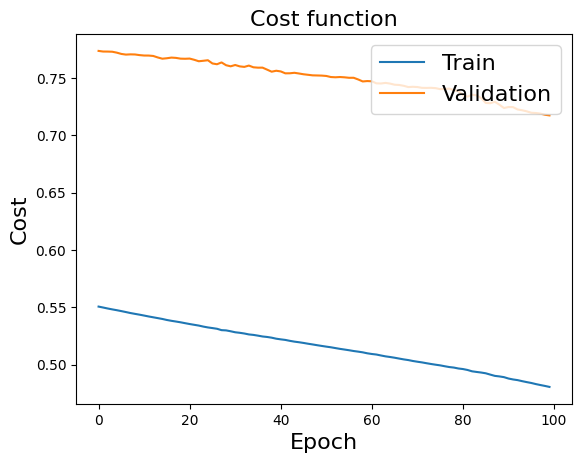

In [ ]:
#Y ahora vemos la función de costo

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

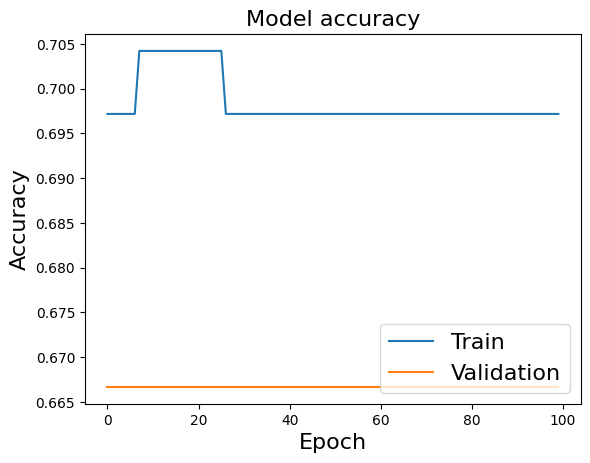

In [ ]:
#Y la función en función de acc

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

In [ ]:
#Evaluamos

evaluations = modell.evaluate(x = x_test_norm, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

1/1 [==============================] - 0s 42ms/step - loss: 2.2968 - accuracy: 0.2778
Loss = 2.2968015670776367
Test Accuracy = 0.2777777910232544


In [ ]:
#Establecemos los hiperparámetros del primero modelo a evaluar

M2capa1 = 10
M2capa2 = 7
M2init = 'uniform'
M2act = 'sigmoid'
M2input = (13,)
M2clas = 3

In [ ]:
model2 = architecture(M2capa1, M2capa2, M2init, M2act, M2input, 3)

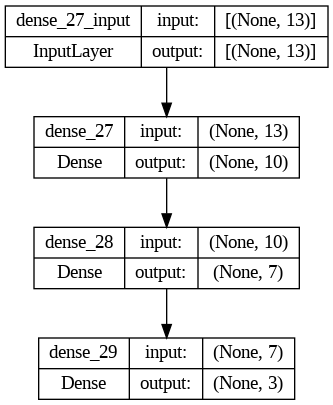

In [ ]:
#Podemos visualizar el modelo

plot_model(model2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Los optimizadores, pérdida y métrica

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
acc = 'accuracy'

In [ ]:
#Y compilamos

model2.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = acc)

In [ ]:
#Para finalmente correrlo

num_epochs = 100

history_model = model2.fit(train_x,train_y, epochs=num_epochs, batch_size = 32, \
                          validation_data=(valid_x,valid_y), shuffle=False, verbose=2)

Epoch 1/100
5/5 - 1s - loss: 1.0962 - accuracy: 0.3310 - val_loss: 1.0910 - val_accuracy: 0.2222 - 1s/epoch - 200ms/step
Epoch 2/100
5/5 - 0s - loss: 1.0946 - accuracy: 0.3944 - val_loss: 1.0873 - val_accuracy: 0.5556 - 65ms/epoch - 13ms/step
Epoch 3/100
5/5 - 0s - loss: 1.0935 - accuracy: 0.3944 - val_loss: 1.0836 - val_accuracy: 0.5556 - 38ms/epoch - 8ms/step
Epoch 4/100
5/5 - 0s - loss: 1.0925 - accuracy: 0.3944 - val_loss: 1.0800 - val_accuracy: 0.5556 - 45ms/epoch - 9ms/step
Epoch 5/100
5/5 - 0s - loss: 1.0917 - accuracy: 0.3944 - val_loss: 1.0766 - val_accuracy: 0.5556 - 42ms/epoch - 8ms/step
Epoch 6/100
5/5 - 0s - loss: 1.0910 - accuracy: 0.3944 - val_loss: 1.0733 - val_accuracy: 0.5556 - 47ms/epoch - 9ms/step
Epoch 7/100
5/5 - 0s - loss: 1.0904 - accuracy: 0.3944 - val_loss: 1.0703 - val_accuracy: 0.5556 - 62ms/epoch - 12ms/step
Epoch 8/100
5/5 - 0s - loss: 1.0898 - accuracy: 0.3944 - val_loss: 1.0674 - val_accuracy: 0.5556 - 52ms/epoch - 10ms/step
Epoch 9/100
5/5 - 0s - loss: 

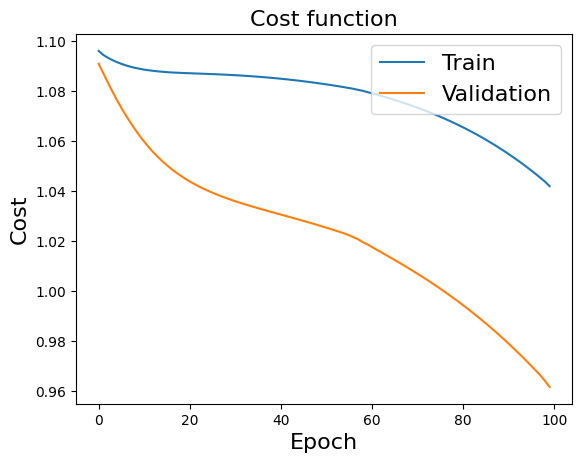

In [ ]:
#Y ahora vemos la función de costo

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

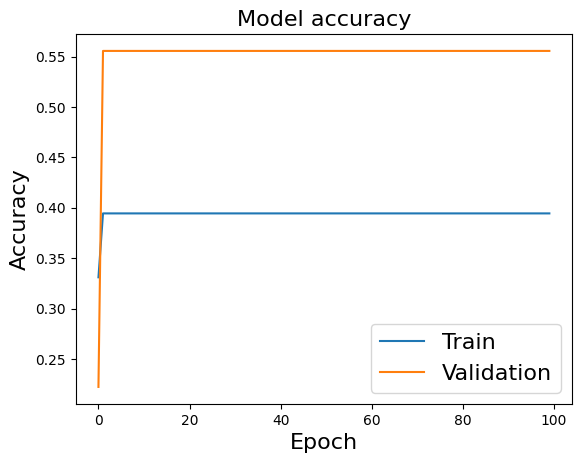

In [ ]:
#Y la función en función de acc

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

In [ ]:
#Evaluamos

evaluations = modell.evaluate(x = x_test_norm, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

1/1 [==============================] - 0s 28ms/step - loss: 2.2968 - accuracy: 0.2778
Loss = 2.2968015670776367
Test Accuracy = 0.2777777910232544


In [ ]:
#Establecemos los hiperparámetros del primero modelo a evaluar

M3capa1 = 20
M3capa2 = 10
M3init = 'uniform'
M3act = 'relu'
M3input = (13,)
M3clas = 3

In [ ]:
model3 = architecture(M3capa1, M3capa2, M3init, M3act, M3input, 3)

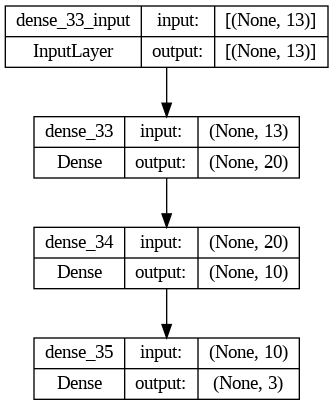

In [ ]:
#Podemos visualizar el modelo

plot_model(model3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Los optimizadores, pérdida y métrica

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
acc = 'accuracy'

In [ ]:
#Y compilamos

model3.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = acc)

In [ ]:
#Para finalmente correrlo

num_epochs = 100

history_model = model3.fit(train_x,train_y, epochs=num_epochs, batch_size = 32, \
                          validation_data=(valid_x,valid_y), shuffle=False, verbose=2)

Epoch 1/100
5/5 - 0s - loss: 0.5751 - accuracy: 0.6761 - val_loss: 0.7894 - val_accuracy: 0.6667 - 107ms/epoch - 21ms/step
Epoch 2/100
5/5 - 0s - loss: 0.5742 - accuracy: 0.6761 - val_loss: 0.7894 - val_accuracy: 0.6667 - 58ms/epoch - 12ms/step
Epoch 3/100
5/5 - 0s - loss: 0.5734 - accuracy: 0.6761 - val_loss: 0.7891 - val_accuracy: 0.6667 - 41ms/epoch - 8ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5725 - accuracy: 0.6761 - val_loss: 0.7891 - val_accuracy: 0.6667 - 59ms/epoch - 12ms/step
Epoch 5/100
5/5 - 0s - loss: 0.5717 - accuracy: 0.6761 - val_loss: 0.7888 - val_accuracy: 0.6667 - 40ms/epoch - 8ms/step
Epoch 6/100
5/5 - 0s - loss: 0.5709 - accuracy: 0.6761 - val_loss: 0.7889 - val_accuracy: 0.6667 - 43ms/epoch - 9ms/step
Epoch 7/100
5/5 - 0s - loss: 0.5701 - accuracy: 0.6761 - val_loss: 0.7890 - val_accuracy: 0.6667 - 41ms/epoch - 8ms/step
Epoch 8/100
5/5 - 0s - loss: 0.5693 - accuracy: 0.6761 - val_loss: 0.7890 - val_accuracy: 0.6667 - 66ms/epoch - 13ms/step
Epoch 9/100
5/5 - 0s - loss

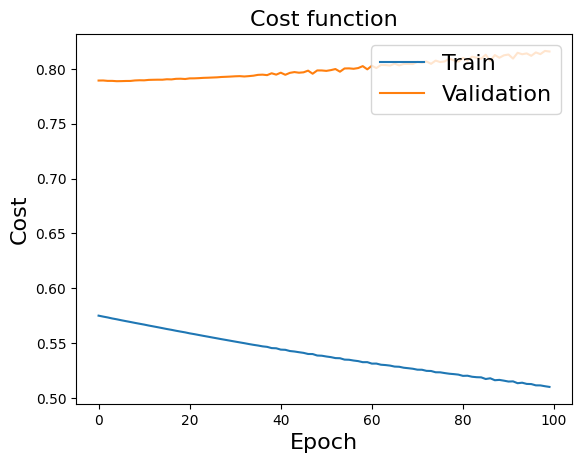

In [ ]:
#Y ahora vemos la función de costo

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

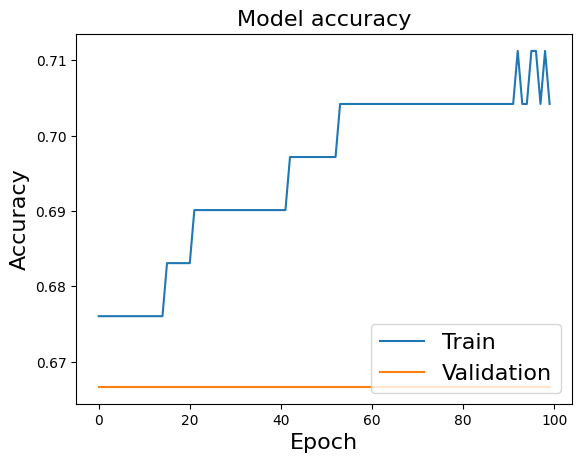

In [ ]:
#Y la función en función de acc

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

In [ ]:
#Evaluamos

evaluations = model3.evaluate(x = x_test_norm, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

1/1 [==============================] - 0s 44ms/step - loss: 1.2265 - accuracy: 0.2778
Loss = 1.2265146970748901
Test Accuracy = 0.2777777910232544


In [ ]:
#Establecemos los hiperparámetros del primero modelo a evaluar

M4capa1 = 15
M4capa2 = 7
M4init = 'uniform'
M4act = 'tanh'
M4input = (13,)
M4clas = 3

In [ ]:
model4 = architecture(M4capa1, M4capa2, M4init, M4act, M4input, 3)

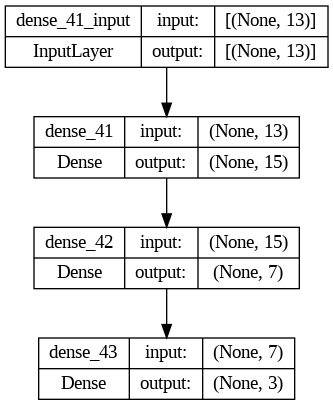

In [ ]:
#Podemos visualizar el modelo

plot_model(model4, to_file='model_4.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Los optimizadores, pérdida y métrica

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
acc = 'accuracy'

In [ ]:
#Y compilamos

model4.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = acc)

In [ ]:
#Para finalmente correrlo

num_epochs = 100

history_model = model4.fit(train_x,train_y, epochs=num_epochs, batch_size = 32, \
                          validation_data=(valid_x,valid_y), shuffle=False, verbose=2)

Epoch 1/100
5/5 - 1s - loss: 1.0985 - accuracy: 0.3803 - val_loss: 1.0951 - val_accuracy: 0.6667 - 951ms/epoch - 190ms/step
Epoch 2/100
5/5 - 0s - loss: 1.0958 - accuracy: 0.6549 - val_loss: 1.0912 - val_accuracy: 0.6667 - 67ms/epoch - 13ms/step
Epoch 3/100
5/5 - 0s - loss: 1.0926 - accuracy: 0.6338 - val_loss: 1.0858 - val_accuracy: 0.6667 - 65ms/epoch - 13ms/step
Epoch 4/100
5/5 - 0s - loss: 1.0891 - accuracy: 0.5845 - val_loss: 1.0799 - val_accuracy: 0.6667 - 60ms/epoch - 12ms/step
Epoch 5/100
5/5 - 0s - loss: 1.0847 - accuracy: 0.5845 - val_loss: 1.0730 - val_accuracy: 0.6667 - 85ms/epoch - 17ms/step
Epoch 6/100
5/5 - 0s - loss: 1.0797 - accuracy: 0.5634 - val_loss: 1.0650 - val_accuracy: 0.6667 - 61ms/epoch - 12ms/step
Epoch 7/100
5/5 - 0s - loss: 1.0735 - accuracy: 0.5986 - val_loss: 1.0564 - val_accuracy: 0.6667 - 92ms/epoch - 18ms/step
Epoch 8/100
5/5 - 0s - loss: 1.0664 - accuracy: 0.6127 - val_loss: 1.0467 - val_accuracy: 0.6667 - 91ms/epoch - 18ms/step
Epoch 9/100
5/5 - 0s -

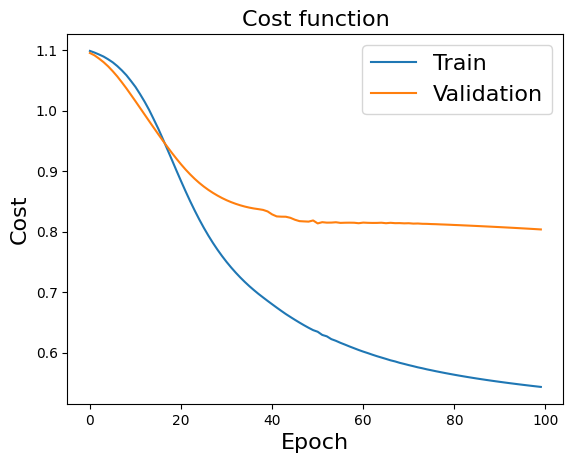

In [ ]:
#Y ahora vemos la función de costo

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

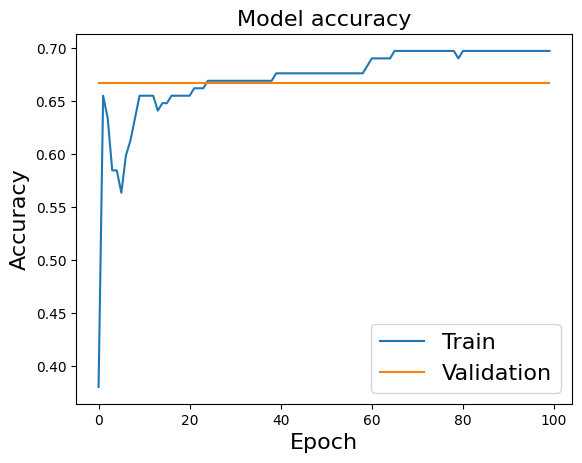

In [ ]:
#Y la función en función de acc

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

In [ ]:
#Evaluamos

evaluations = model4.evaluate(x = x_test_norm, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

1/1 [==============================] - 0s 274ms/step - loss: 1.0840 - accuracy: 0.2778
Loss = 1.0840086936950684
Test Accuracy = 0.2777777910232544


Conclusión: Con esta realización de entrenamientos, se pudo ver una pequeña variación de ciertos hiperparámetros para una red más eficiente, sin embargo, no existió una red que superara el 66% de accuracy a pesar de los esfuerzos de hacerlo.

Esto puede indicar que, en efecto, es muy dificil la variación de hiperparámetros que consigan una red óptima y efectiva.

A pesar de ello, la primera y última representación gráfica mosstraron que en pocas épocas hubo un aprendimiento pero después éste divergió.